# Évaluation de la significativité d’un modèle de régression par test de permutation
---
> **Emmanuel Evilafo**
<br>Site web 👉 [https://evilafo.xyz](https://evilafo.xyz)

## Sommaire
- [Rapport](#rapport)
- [Code final et résultats](#code_final)

## <u>Rapport</u>
### Contexte

Dans le cadre de ce projet, nous avons simulé un petit jeu de données composé de **8 molécules** décrites par **3 descripteurs** (tirés d’une loi normale standard) et d’une variable réponse **activité biologique**.
L’objectif est de vérifier si un modèle de régression linéaire parvient réellement à capturer une relation significative entre les descripteurs et l’activité, ou si les résultats obtenus pourraient simplement être dus au hasard.

Pour cela, nous utilisons le **test de permutation (Y-scrambling)**, une méthode statistique qui consiste à comparer le pouvoir prédictif du modèle sur les données originales avec celui obtenu sur des versions où la variable réponse est aléatoirement permutée.

### Méthodologie

1. **Validation croisée Leave-One-Out (LOO)**

   * Mise en place d’une fonction `q2_loo` calculant le Q² prédictif via LOO.
   * Le Q² est une mesure analogue au R² mais appliquée dans un contexte de validation croisée.

2. **Test de permutation**

   * Si la taille de l’échantillon le permet (n! ≤ 50 000), on calcule toutes les permutations possibles (test exact).
   * Sinon, on effectue un grand nombre de permutations aléatoires (ici 1 000).
   * À chaque permutation, on recalcule Q² pour obtenir une distribution empirique représentant le « niveau du hasard ».
   * On calcule la **p-valeur** comme la proportion de Q² permutés supérieurs ou égaux au Q² observé.

3. **Visualisation**

   * Histogramme de la distribution des Q² permutés, avec indication du Q² observé et de la moyenne des Q² permutés.
   * Nuage de points des valeurs observées vs. prédites, accompagné de la diagonale idéale et de la droite de régression réelle.

### Modifications apportées au code initial

* **Refonte de la fonction `test_permutation`** :

  * Ajout d’une distinction entre **test exact** et **test aléatoire** en fonction de la taille de l’échantillon.
  * Intégration de messages d’information (nombre de permutations, type de test utilisé).
  * Retour des résultats principaux : Q² observé, distribution des Q² permutés, p-valeur.

* **Ajout de la fonction `tracer_regression`** :

  * Tracé du nuage de points y observé vs. y prédit.
  * Ajout de la diagonale (y = ŷ), de la droite de régression ajustée et des métriques (pente, intercept, R²).

* **Amélioration des visualisations** :

  * Histogramme clair avec couleurs, légende et annotation de la moyenne permutée.
  * Mise en page améliorée (titres, axes, légendes).

* **Organisation du code principal** :

  * Simulation des données `X` et `y`.
  * Affichage des données sous forme de tableau Pandas.
  * Appel du test de permutation et impression des résultats synthétiques.
  * Génération des graphiques d’interprétation.

### Résultats attendus

* Le **Q² observé** doit être comparé à la **moyenne des Q² permutés**.
* Si le Q² observé est significativement plus élevé et que la **p-valeur est faible**, on conclut que le modèle capture une relation réelle et non aléatoire.
* Les graphiques permettent de visualiser à la fois la robustesse du modèle (permutation test) et son ajustement (nuage de points).

## Code final et résultats
<h1 id="code_final"></h1>

#### La fonction

In [1]:
import numpy as np
import itertools, math
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def q2_loo(modele, X, y):
    """Calcule le Q² avec une validation croisée Leave-One-Out."""
    loo = LeaveOneOut()
    y_pred = cross_val_predict(modele, X, y, cv=loo)
    ss_res = np.sum((y - y_pred)**2)              # somme des carrés des résidus
    ss_tot = np.sum((y - np.mean(y))**2)          # somme des carrés totale
    return 1 - ss_res/ss_tot

def test_permutation(X, y, modele=None, n_permutations=1000, tracer=True):
    """
    Test de permutation.
    - Si n! <= 50k : test exact (toutes les permutations).
    - Sinon : tirage aléatoire (n_permutations).
    
    Retourne : Q² observé, distribution des Q² permutés, et p-valeur.
    """
    if modele is None:
        modele = LinearRegression()
    
    y = np.asarray(y)
    n = len(y)

    q2_obs = q2_loo(modele, X, y)   # Q² observé
    total_perms = math.factorial(n)
    q2_perm = []

    if total_perms <= 50000:   # test exact
        print(f"🔎 Test exact sur toutes les {total_perms} permutations...")
        perms = itertools.permutations(range(n))
        for perm in perms:
            y_perm = y[list(perm)]
            q2_perm.append(q2_loo(modele, X, y_perm))
    else:   # test aléatoire
        print(f"Jeu de données trop grand pour le test exact (n! = {total_perms:,}).")
        print(f"Test par tirages aléatoires avec {n_permutations} permutations...")
        rng = np.random.default_rng(42)
        for _ in range(n_permutations):
            perm = rng.permutation(n)
            y_perm = y[perm]
            q2_perm.append(q2_loo(modele, X, y_perm))
    
    q2_perm = np.array(q2_perm)
    p_val = np.mean(q2_perm >= q2_obs)   # p-value

    # === Tracé histogramme des permutations ===
    if tracer:
        plt.figure(figsize=(6,4))
        plt.hist(q2_perm, bins=20, color="lightblue", edgecolor="k")
        plt.axvline(q2_obs, color="red", linestyle="dashed", linewidth=2,
                    label=f"Q² observé = {q2_obs:.3f}")
        plt.axvline(q2_perm.mean(), color="green", linestyle="dotted", linewidth=2,
                    label=f"Moyenne permutée = {q2_perm.mean():.3f}")
        plt.title("Distribution des Q² après permutation")
        plt.xlabel("Q² (Leave-One-Out)")
        plt.ylabel("Fréquence")
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return q2_obs, q2_perm, p_val

def tracer_regression(X, y, modele):
    """
    Trace le nuage de points (y observé vs y prédit),
    la diagonale, la droite de régression réelle
    et affiche les métriques (R², pente, intercept).
    """
    y = np.asarray(y)
    modele.fit(X, y)
    y_pred = modele.predict(X)

    # Ajustement de la droite réelle entre y et ŷ
    reg = LinearRegression()
    reg.fit(y.reshape(-1,1), y_pred)
    y_line = np.linspace(y.min(), y.max(), 100)
    y_pred_line = reg.predict(y_line.reshape(-1,1))

    # Calcul R²
    r2 = r2_score(y, y_pred)

    # === Tracé ===
    plt.figure(figsize=(6,6))
    plt.scatter(y, y_pred, color="blue", edgecolor="k", alpha=0.7, label="Points")
    # diagonale 
    plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2, label="y = ŷ")
    # droite de régression réelle
    plt.plot(y_line, y_pred_line, "g-", lw=2, label="Droite de régression")

    plt.xlabel("Valeurs observées (y)")
    plt.ylabel("Valeurs prédites (ŷ)")
    plt.title("Nuage de points et droites de régression")
    plt.legend()

    # Annotation avec métriques
    eq = f"ŷ = {reg.coef_[0]:.2f}·y + {reg.intercept_: .2f}\nR² = {r2:.3f}"
    plt.text(0.05, 0.95, eq, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment="top",
             bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    plt.tight_layout()
    plt.show()

#### L'utilisation


📋 Molécules simulées :
      X1     X2     X3    y
0 -0.846  0.510  0.512  5.1
1 -0.910  2.238  0.081  4.8
2  0.240 -0.173 -0.589  6.3
3 -0.239 -0.404 -0.558  7.0
4 -1.057  0.699 -0.962  5.5
5  0.315 -1.250  2.014  4.9
6 -0.308 -1.767 -0.788  6.1
7  0.691  0.339  0.052  5.7
🔎 Test exact sur toutes les 40320 permutations...


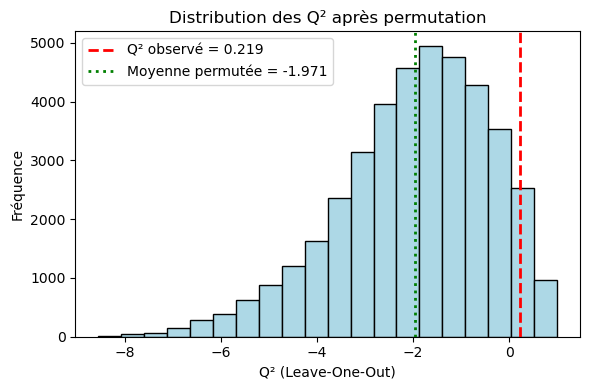


 Résultats de la régression :
 - Q² observé = 0.2191241157229109
 - Moyenne des Q² permutés (le niveau du hasard) = -1.9706488240007942
 - Maximum des Q² permutés = 0.9924814221250808
 - p-value basée sur permutation = 0.05900297619047619


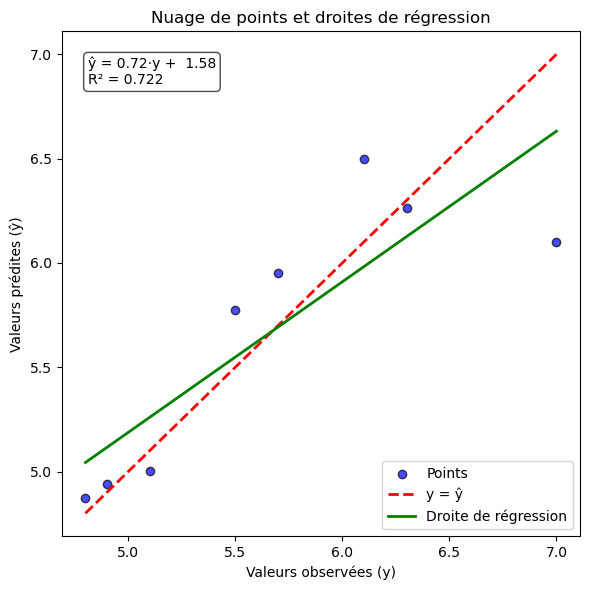

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 1.91 μs


In [2]:
import pandas as pd

if __name__ == "__main__":
    # Jeu de données fictif (On va remplacer par les vrais X, y)
    X = np.random.randn(8, 3)   # 8 molécules × 3 descripteurs
    y = np.array([5.1, 4.8, 6.3, 7.0, 5.5, 4.9, 6.1, 5.7])
    
    # On met X et y dans un tableau pandas
    df = pd.DataFrame(X, columns=[f"X{i+1}" for i in range(X.shape[1])])
    df["y"] = y
    print("\n📋 Molécules simulées :")
    print(df.round(3))   # arrondi à 3 décimales
    
    modele = LinearRegression()
    q2_obs, q2_perm, p_val = test_permutation(X, y, modele=modele,
                                              n_permutations=1000, tracer=True)
    
    print("\n Résultats de la régression :")
    print(" - Q² observé =", q2_obs)
    print(" - Moyenne des Q² permutés (le niveau du hasard) =", q2_perm.mean())
    print(" - Maximum des Q² permutés =", q2_perm.max())
    print(" - p-value basée sur permutation =", p_val)

    # Nuage de points + droites
    tracer_regression(X, y, modele)
%time

#### Molécules simulées

In [3]:
df_affiche = df.rename(columns={"y": "y (cible)"})
df_affiche.round(3)

,X1,X2,X3,y (cible)
0,-0.846,0.510,0.512,5.1
1,-0.910,2.238,0.081,4.8
2,0.240,-0.173,-0.589,6.3
3,-0.239,-0.404,-0.558,7.0
4,-1.057,0.699,-0.962,5.5
5,0.315,-1.250,2.014,4.9
6,-0.308,-1.767,-0.788,6.1
7,0.691,0.339,0.052,5.7
